In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint ,TensorBoard, EarlyStopping
import tensorflow as tf
import datetime, IPython
import numpy as np
import os


In [2]:
config=tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU')) 


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def stop_cuda():
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()

In [4]:
path = os.getcwd()

In [5]:
#train_dir = '/home/jidesh/ML/CNN/Facial-expression/data/train'
train_dir = path+'/dataset/FacialExpression-Dataset/Train'
val_dir = path+'/dataset/FacialExpression-Dataset/Test'

checkpoint_losspath = path+'/Checkpoints/checkpoints_loss/Model-epoch_{epoch:02d}--val_loss_{val_loss:.2f}'
checkpoint_accpath = path+'/Checkpoints/checkpoints_acc/Model-epoch_{epoch:02d}--val_categorical_accuracy_{val_categorical_accuracy:.2f}'


train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 64
img_width = 48
img_height = 48

print("Train : ",train_dir)
print("Val : ",val_dir)

Train :  d:\project\project/dataset/FacialExpression-Dataset/Train
Val :  d:\project\project/dataset/FacialExpression-Dataset/Test


In [6]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')


Found 76577 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
print("Train set size : {} class : {} no.of : {}".format(train_generator.samples,train_generator.class_indices,train_generator.num_classes))
train_sample_size = train_generator.samples
validation_sample_size = validation_generator.samples
print("validate set size : {} class : {} no.of : {}".format(validation_generator.samples,validation_generator.class_indices,validation_generator.num_classes))

Train set size : 76577 class : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6} no.of : 7
validate set size : 7178 class : {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6} no.of : 7


In [8]:
emotion_model = Sequential()
 
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(img_height,img_width,1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.3))
 
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.3))


emotion_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))

emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.3))
 
emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(train_generator.num_classes, activation='softmax'))
################################################################################
#emotion_model.load_weights(path+'/Models/emotion-reg-weight-0.8510841131210327.h5')

In [9]:
emotion_dict = train_generator.class_indices
print(emotion_dict)
#swapping key and values in dictionary
emotion_dict={value:key for key, value in emotion_dict.items()}
print(emotion_dict)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [10]:
checkpoint_loss = ModelCheckpoint(
    filepath=checkpoint_losspath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose =1
)
checkpoint_acc = ModelCheckpoint(
    filepath=checkpoint_accpath,
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    verbose =1
)
earlystop = EarlyStopping(monitor='val_loss', patience=20,mode='min')
#Tensorboard
time1 = (datetime.datetime.now() ).strftime('%c')
time1 = time1.replace(':','_')
#time1 = time1.replace(' ','_')
tensorboard = TensorBoard(path+'/Tensorboard/'+time1)
callback = [checkpoint_loss,checkpoint_acc,tensorboard,earlystop]

--------------------------------------------------------------------------------------------------------------------------------------------------

**Nadam Optimiser**

In [11]:
emotion_model.compile(loss='categorical_crossentropy',optimizer=Nadam(learning_rate=0.001),metrics=['categorical_accuracy'])
emotion_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 512)       5

In [12]:
#%%time
emotion_model_info = emotion_model.fit(
        train_generator,
        steps_per_epoch=train_sample_size // batch_size,
        epochs=120,
        validation_data=validation_generator,
        validation_steps=validation_sample_size // batch_size,
        callbacks=callback)

Epoch 1/120
1196/1196 [==============================] - 67s 52ms/step - loss: 1.6095 - categorical_accuracy: 0.3718 - val_loss: 1.3348 - val_categorical_accuracy: 0.4951

Epoch 00001: val_loss improved from inf to 1.33476, saving model to d:\project\project/Checkpoints/checkpoints_loss\Model-epoch_01--val_loss_1.33
INFO:tensorflow:Assets written to: d:\project\project/Checkpoints/checkpoints_loss\Model-epoch_01--val_loss_1.33\assets

Epoch 00001: val_categorical_accuracy improved from -inf to 0.49512, saving model to d:\project\project/Checkpoints/checkpoints_acc\Model-epoch_01--val_categorical_accuracy_0.50
INFO:tensorflow:Assets written to: d:\project\project/Checkpoints/checkpoints_acc\Model-epoch_01--val_categorical_accuracy_0.50\assets
Epoch 2/120
1196/1196 [==============================] - 59s 49ms/step - loss: 1.2071 - categorical_accuracy: 0.5447 - val_loss: 1.1738 - val_categorical_accuracy: 0.5646

Epoch 00002: val_loss improved from 1.33476 to 1.17377, saving model to d:\p

In [13]:
path1 = path+'/Models'
emotion_model1=emotion_model
emotion_model1.save(path1+'/nadam')
emotion_model.save_weights(path1+f"/nadam_weights/emotion-reg-weight-{emotion_model_info.history['categorical_accuracy'][-1]}"+".h5")

INFO:tensorflow:Assets written to: d:\project\project/Models/nadam\assets


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


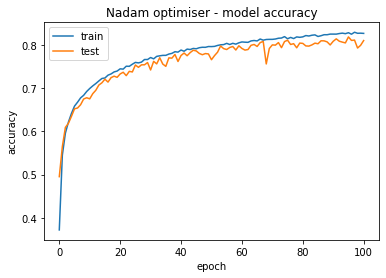

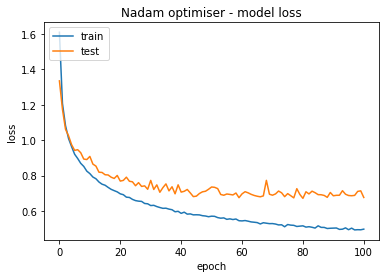

In [14]:
# list all data in history
print(emotion_model_info.history.keys())
# summarize history for accuracy
plt.plot(emotion_model_info.history['categorical_accuracy'])
plt.plot(emotion_model_info.history['val_categorical_accuracy'])
plt.title('Nadam optimiser - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(emotion_model_info.history['loss'])
plt.plot(emotion_model_info.history['val_loss'])
plt.title('Nadam optimiser - model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------

In [15]:
%load_ext tensorboard
%tensorboard --logdir path+'/Tensorboard/'

Reusing TensorBoard on port 6006 (pid 17032), started 2 days, 3:58:47 ago. (Use '!kill 17032' to kill it.)

-------------------------------------------------------------------------------------------------------------------------------------------------

**Convolution Matrix**

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
target_names = list(emotion_dict.values())
print(target_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [18]:
y_pred=emotion_model.predict(train_generator)
y_pred=np.argmax(y_pred,axis=1)
print('confusion matrix')
cm=confusion_matrix(train_generator.classes,y_pred)
print(cm)

confusion matrix
[[1252 1259 1156 2180 1403 1362 1399]
 [1247 1352 1157 2073 1484 1311 1386]
 [1293 1362 1170 2121 1430 1268 1367]
 [2046 2273 1833 3473 2260 2098 2281]
 [1223 1335 1156 2098 1443 1410 1372]
 [1278 1350 1175 2246 1448 1340 1396]
 [1259 1269 1278 2165 1416 1282 1342]]


In [19]:
y_pred=emotion_model.predict(validation_generator)
y_pred=np.argmax(y_pred,axis=1)
print('confusion matrix')
cm=confusion_matrix(validation_generator.classes,y_pred)
print(cm)

confusion matrix
[[126  11 103 243 183 181 111]
 [ 15   2   7  24  15  31  17]
 [130  27 119 264 173 207 104]
 [246  34 174 448 341 317 214]
 [164  22 144 304 230 207 162]
 [157  24 138 304 227 239 158]
 [106  11  94 204 165 158  93]]


C:\Users\logesh\AppData\Local\Temp/ipykernel_14428/2774912854.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_names)
C:\Users\logesh\AppData\Local\Temp/ipykernel_14428/2774912854.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_names)


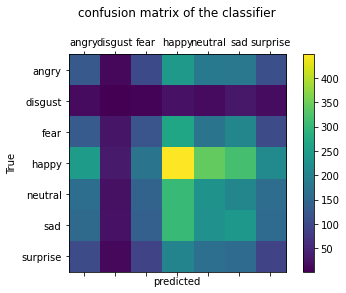

In [20]:
fig=plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(cm)
plt.title('confusion matrix of the classifier\n')
fig.colorbar(cax)
ax.set_xticklabels([''] + target_names)
ax.set_yticklabels([''] + target_names)
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()

In [21]:
Y_pred = emotion_model.predict(validation_generator, 400 // 4)

y_pred = np.argmax(Y_pred, axis=1)
print(validation_generator.classes)

print('Confusion Matrix')

cfm = confusion_matrix(validation_generator.classes, y_pred)

print(cfm)

[0 0 0 ... 6 6 6]
Confusion Matrix
[[127  12  95 241 190 191 102]
 [ 14   4  15  26  17  26   9]
 [130  18 108 245 195 198 130]
 [239  31 194 433 332 327 218]
 [158  26 141 326 213 230 139]
 [155  24 131 320 234 237 146]
 [121  16  95 200 153 131 115]]


In [22]:
print(classification_report(validation_generator.classes,y_pred))

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       958
           1       0.03      0.04      0.03       111
           2       0.14      0.11      0.12      1024
           3       0.24      0.24      0.24      1774
           4       0.16      0.17      0.17      1233
           5       0.18      0.19      0.18      1247
           6       0.13      0.14      0.14       831

    accuracy                           0.17      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.17      0.17      0.17      7178



--------------------------------------------------------------------------------------------------------------------------------------------

In [23]:
# %%javascript
# IPython.notebook.save_notebook()

In [24]:
# #pip install twilio
# from twilio.rest import Client

In [25]:
# import json
 
# # Opening JSON file
# f = open(path+'/twilo.json')
 
# # returns JSON object as
# # a dictionary
# data = json.load(f)
 
# # Iterating through the json
# # list
# print(data)
 
# # Closing file
# f.close()

In [26]:
# message =f"Accuracy : {emotion_model_info.history['categorical_accuracy'][-1]} Loss : {emotion_model_info.history['loss'][-1]} val_accuracy : {emotion_model_info.history['val_categorical_accuracy'][-1]} val_loss : {emotion_model_info.history['val_loss'][-1]}"

# # # Your Account Sid and Auth Token from twilio account

# # # instantiating the Client
# client = Client(data['account_sid'], data['auth_token'])
# # # sending message
# message = client.messages.create(body=message, from_= '+917305746782', to='+917305746782')
# # # printing the sid after success
# print(message.sid)

In [27]:
import os
len(os.listdir(path+'/dataset/FacialExpression-Dataset/Train/angry'))

10011

In [28]:
# #compress tensorboard data and check ponits
# checkpoints = shutil.make_archive('Checkpoints', "zip", path+'/Checkpoints/zip')
# tensorboard = shutil.make_archive('Tensorboard',"zip",path+'/Tensorboard/zip')

In [29]:
# from google.colab import files
# from shutil import  copy2

# t = input("C to copy to drive , D to download")
# if t == 'c' or t == 'C':
#   copy2('/content/Checkpoints.zip','/content/drive/MyDrive/7thSem_project/Checkpoints.zip')
#   copy2('/content/Tensorboard.zip','/content/drive/MyDrive/7thSem_project/Tensorboard.zip')
# elif t == 'd' or t =='D':

#   files.download('/content/Checkpoints.zip')

#   files.download('/content/Tensorboard.zip')

------------------------------------------------------------------------------------------------------------------------------------------------------

In [30]:
# import cv2
# import numpy as np

In [31]:
# # start the webcam feed
# cap = cv2.VideoCapture(0)
# while True:
#     # Find haar cascade to draw bounding box around face
#     ret, frame = cap.read()
#     if not ret:
#         break
#     bounding_box = cv2.CascadeClassifier('C:\\Users\\logesh\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\cv2\\data\\haarcascade_frontalface_default.xml')
#     gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     num_faces = bounding_box.detectMultiScale(gray_frame,scaleFactor=1.3, minNeighbors=5)

#     for (x, y, w, h) in num_faces:
#         cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
#         roi_gray_frame = gray_frame[y:y + h, x:x + w]
#         cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
#         emotion_prediction = emotion_model.predict(cropped_img)
#         maxindex = int(np.argmax(emotion_prediction))
#         cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

#     cv2.imshow('Facial Expression', cv2.resize(frame,(1200,860),interpolation = cv2.INTER_CUBIC))    
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

In [32]:
# cap.release()
# cv2.destroyAllWindows()

In [33]:
stop_cuda()

In [2]:
# import seaborn
# import matplotlib.pyplot as plt
 
 
# def plot_confusion_matrix(data, labels, output_filename):
#     """Plot confusion matrix using heatmap.
 
#     Args:
#         data (list of list): List of lists with confusion matrix data.
#         labels (list): Labels which will be plotted across x and y axis.
#         output_filename (str): Path to output file.
 
#     """
#     seaborn.set(color_codes=True)
#     plt.figure(1, figsize=(16, 10))
 
#     plt.title("Confusion Matrix")
 
#     seaborn.set(font_scale=1.4)
#     ax = seaborn.heatmap(data, fmt='g', annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
#     ax.set_xticklabels(labels)
#     ax.set_yticklabels(labels)
 
#     ax.set(ylabel="True Label", xlabel="Predicted Label")
#     plt.show()
#     plt.savefig(output_filename, bbox_inches='tight', dpi=300)
#     plt.close()


# cm = [[127,  12,  95, 241, 190, 191, 102],
#  [ 14,   4,  15,  26,  17,  26,   9],
#  [130,  18, 108, 245, 195, 198, 130],
#  [239,  31, 194, 433, 332, 327, 218],
#  [158,  26, 141, 326, 213, 230, 139],
#  [155,  24, 131, 320, 234, 237, 146],
#  [121,  16,  95, 200, 153, 131, 115]]

# target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
 

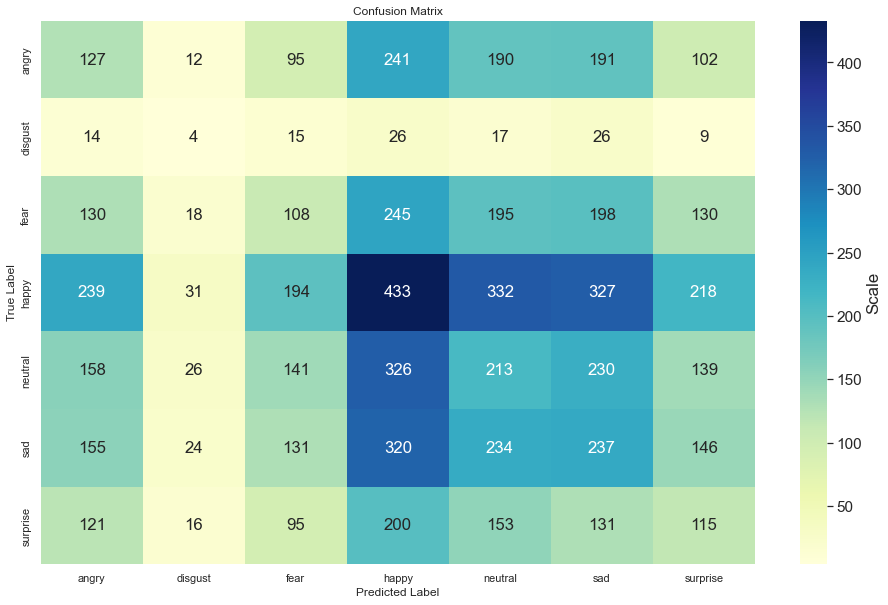

In [3]:
# plot_confusion_matrix(cm, target_names, "nadam_confusion_matrix.png")